In [1]:
from ANNarchy import *
from ANNarchy.extensions.bold import *

import numpy as np
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK

ANNarchy 4.7 (4.7.2.4) on darwin (posix).


In [2]:
def trial(args):

    noise = args['noise']

    clear()

    pop0 = Population(100, neuron=Izhikevich)
    pop1 = Population(100, neuron=Izhikevich)

    # Set noise to create some baseline activity
    pop0.noise = 5.0; pop1.noise = 5.0

    # Compute mean firing rate in Hz on 100ms window
    pop0.compute_firing_rate(window=100.0)
    pop1.compute_firing_rate(window=100.0)

    # Record the mean firing rate
    mon_pop0 = Monitor(pop0, ["r"])
    mon_pop1 = Monitor(pop1, ["r"])

    m_bold = BoldMonitor(
        
        populations = [pop0, pop1], # recorded populations
        
        bold_model = balloon_RN(), # BOLD model to use (default is balloon_RN)
        
        mapping = {'I_CBF': 'r'}, # mapping from pop.r to I_CBF
        
        normalize_input = 2000,  # time window to compute baseline.
        
        recorded_variables = ["I_CBF", "BOLD"]  # variables to be recorded
    )

    compile()

    m_bold.start()

    # We manipulate the noise for the half of the neurons
    simulate(5000)      # 5s with low noise
    pop0.noise = noise
    simulate(5000)      # 5s with higher noise (one population)
    pop0.noise = 5
    simulate(20000)     # 10s with low noise

    # Retrieve the recordings
    mean_fr1 = np.mean(mon_pop0.get("r"), axis=1)
    mean_fr2 = np.mean(mon_pop1.get("r"), axis=1)

    input_data = m_bold.get("I_CBF")
    bold_data = m_bold.get("BOLD")

    # Compute the loss
    max_bold = bold_data.max()
    loss = (max_bold - 0.05)**2

    return {
        'loss': loss,
        'status': STATUS_OK,
        # -- store other results like this
        'mean_fr1': mean_fr1,
        'mean_fr2': mean_fr2,
        'input_data': input_data,
        'bold_data': bold_data,
        }

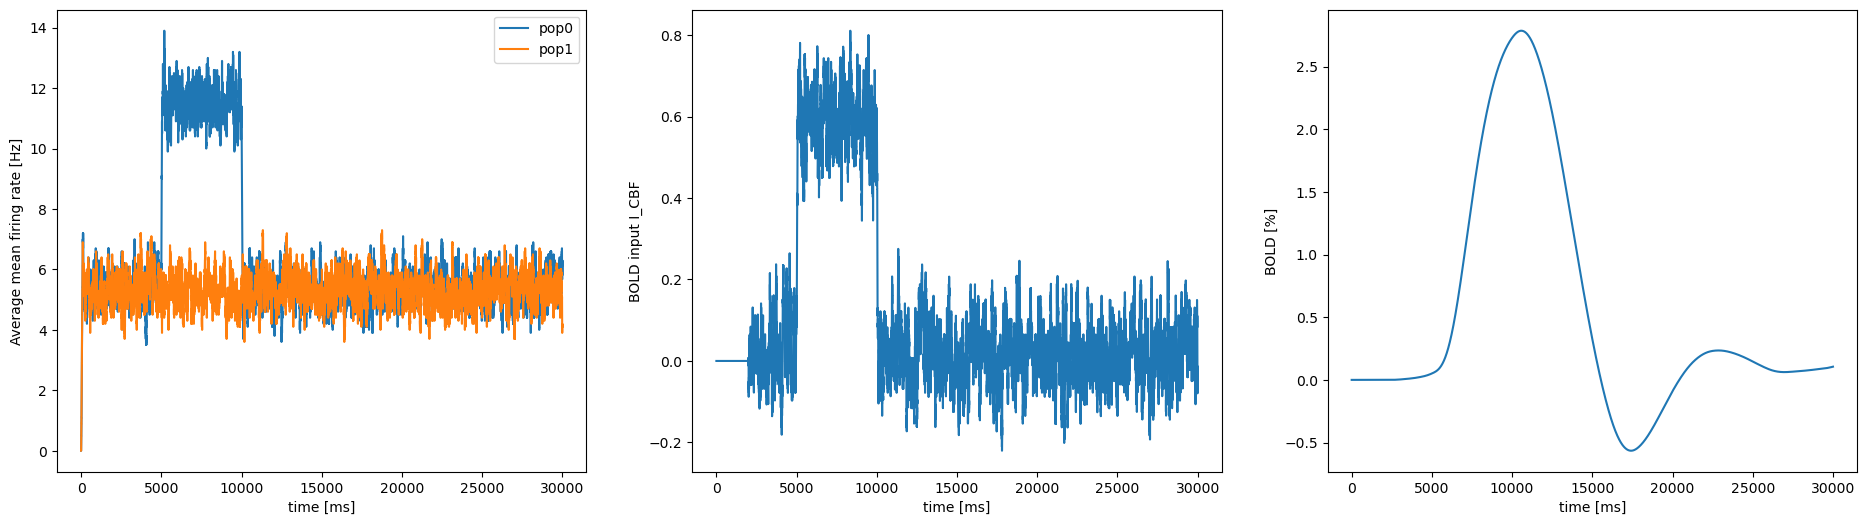

In [3]:
data = trial({'noise': 7.5})


plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])

ax1.plot(data['mean_fr1'], label="pop0")
ax1.plot(data['mean_fr2'], label="pop1")
plt.legend()
ax1.set_ylabel("Average mean firing rate [Hz]")

# BOLD input signal
ax2 = plt.subplot(grid[0, 1])

ax2.plot(data['input_data'])
ax2.set_ylabel("BOLD input I_CBF")

# BOLD output signal
ax3 = plt.subplot(grid[0, 2])

ax3.plot(data['bold_data']*100.0)
ax3.set_ylabel("BOLD [%]")

# x-axis labels as seconds
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("time [ms]")

plt.show()

In [4]:
best = fmin(
    fn=trial,
    space=[
        hp.uniform('noise', 5.0, 10.0), 
    ],
    algo=tpe.suggest,
    max_evals=10)
print(best)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: tuple indices must be integers or slices, not str



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
data = trial(best)

plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, left=0.05, right=0.95)

# mean firing rate
ax1 = plt.subplot(grid[0, 0])

ax1.plot(data['mean_fr1'], label="pop0")
ax1.plot(data['mean_fr2'], label="pop1")
plt.legend()
ax1.set_ylabel("Average mean firing rate [Hz]")

# BOLD input signal
ax2 = plt.subplot(grid[0, 1])

ax2.plot(data['input_data'])
ax2.set_ylabel("BOLD input I_CBF")

# BOLD output signal
ax3 = plt.subplot(grid[0, 2])

ax3.plot(data['bold_data']*100.0)
ax3.set_ylabel("BOLD [%]")

# x-axis labels as seconds
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("time [ms]")

plt.show()

KeyError: 0